In [1]:
%pylab inline

import os
import itertools as it
from astropy.io import fits
from astropy.stats import signal_to_noise_oir_ccd as SNR_astropy
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.ndimage.filters import gaussian_filter
from matplotlib.colors import ColorConverter

cc = ColorConverter()

from tools.stats import err, binner

from styles.slides import *
from styles.colors import *
from styles.labels import *

Populating the interactive namespace from numpy and matplotlib


In [6]:
def residual_table(residuals, masks, residual_labels, mask_labels, keywords):

    for i in xrange(len(keywords)):
        bias_a, pres_a = [], []
        bias_b, pres_b = [], []
        bias_c, pres_c = [], []
        for mask in masks:
            bias_a.append(median(residuals[0][keywords[i]][mask]))
            pres_a.append(diff(percentile(residuals[0][keywords[i]][mask], [16,84]))[0]*0.5)

            bias_b.append(median(residuals[1][keywords[i]][mask]))
            pres_b.append(diff(percentile(residuals[1][keywords[i]][mask], [16,84]))[0]*0.5)

            bias_c.append(median(residuals[2][keywords[i]][mask]))
            pres_c.append(diff(percentile(residuals[2][keywords[i]][mask], [16,84]))[0]*0.5)

        for j in xrange(len(masks)):
            if j==0:
                print r"\multirow{3}{*}{%s}   &%10s &%10.3f &%10.3f & &%10.3f &%10.3f & &%10.3f &%10.3f\\" %\
                (residual_labels[i], mask_labels[j], bias_a[j], pres_a[j], bias_b[j], pres_b[j], bias_c[j], pres_c[j])
            else:
                print r"                          &%10s &%10.3f &%10.3f & &%10.3f &%10.3f & &%10.3f &%10.3f\\" %\
                (mask_labels[j], bias_a[j], pres_a[j], bias_b[j], pres_b[j], bias_c[j], pres_c[j])
        print r"\hline"

def plot_residual_hist(residuals, labels, keywords, res_lbs, limits=((-0.7, 0.7), (1.3, 3.0)), colors=((samples["light"], samples["dark"]), "#218380"), nbins=15):
    residual_a, residual_b = residuals
    color_a, color_b = colors
    label_a, label_b = labels
    xlm, ylm = limits

    fig, axs = subplots(1, len(keywords), figsize=(10, 5), sharex=True, sharey=True)

    axr = []
    for ax in axs:
        divider = make_axes_locatable(ax)
        axr.append(divider.append_axes("top", size="60%", pad=0.07, sharex=ax))

        plt.setp(axr[-1].get_xticklabels()+([] if ax.is_first_col() else axr[-1].get_yticklabels()), visible=False)
        axr[-1].set_ylim(0, 1.2)

    axs = row_stack((axr, axs))

    axs[0, 0].set_xlim(xlm)
    axs[0, 0].set_xticks([-0.4, 0, 0.4])
    axs[0, 0].set_ylabel(r"\bf $N/N_\text{max}$")
    axs[1, 0].set_ylabel(r"\bf $u-r$")

    for i, j in it.product(xrange(axs.shape[0]), xrange(axs.shape[1])):
        if i==0:
            med_a = median(residual_a[keywords[j]])
            p16_a, p84_a = percentile(residual_a[keywords[j]], [16.0, 84.0])

            med_b = median(residual_b[keywords[j]])
            p16_b, p84_b = percentile(residual_b[keywords[j]], [16.0, 84.0])

            N_a = histogram(residual_a[keywords[j]], 20, range=xlm)[0].max().repeat(residual_a[keywords[j]].size)
            N_b = histogram(residual_b[keywords[j]], 20, range=xlm)[0].max().repeat(residual_b[keywords[j]].size)

            axs[i, j].hist(residual_b[keywords[j]], 20, range=xlm, weights=1.0/N_b, histtype="stepfilled", color=color_b, lw=0, label=label_b, alpha=0.5)
            axs[i, j].hist(residual_a[keywords[j]], 20, range=xlm, weights=1.0/N_a, histtype="stepfilled", color=color_a[1], lw=0, label=label_a)

            med_a_axes = axs[i, j].transAxes.inverted().transform(axs[i, j].transData.transform((med_a, 0.0)))+array([0,0.2])
            med_b_axes = axs[i, j].transAxes.inverted().transform(axs[i, j].transData.transform((med_b, 0.0)))+array([0,0.2])
            axs[i, j].annotate("", med_a_axes, (med_a,0.0), "axes fraction", "data", {"arrowstyle":"wedge","fc":color_a[0],"ec":"none"})
            axs[i, j].annotate("", med_b_axes, (med_b,0.0), "axes fraction", "data", {"arrowstyle":"wedge","fc":color_b,"ec":"none"})
        else:
            xa, ya, ea = binner(lcolor, residual_a[keywords[j]], nbins, ylm, "median")
            xb, yb, eb = binner(lcolor, residual_b[keywords[j]], nbins, ylm, "median")

            axs[i, j].plot(gaussian_filter(yb,1.5), xb, "-", color=color_b, lw=2)
            axs[i, j].fill_betweenx(xb, gaussian_filter(yb-eb[0],1.5), gaussian_filter(yb+eb[1],1.5), facecolor=color_b, lw=0, alpha=0.5)

            axs[i, j].plot(gaussian_filter(ya,1.5), xa, "-", color=color_a[0], lw=1.5)
            axs[i, j].fill_betweenx(xa, gaussian_filter(ya-ea[0],1.5), gaussian_filter(ya+ea[1],1.5), facecolor=color_a[1], lw=0)

            axs[i, j].axvline(ls=":", color="k", lw=0.7)
            axs[i, j].axhline(2.22, ls=":", color="k", lw=0.7)

            axs[i, j].set_xlabel(res_lbs[keywords[j]])

    axs[1, 0].set_ylim(xa[0], xa[-1])
    axs[0, 0].legend(loc=1)

    fig.tight_layout()
    fig.subplots_adjust(wspace=0.05)
    
    return None

In [3]:
def N_pix_spec(R=1800., D=3., ps=0.396):
    return 2*R*D/ps

def N_pix_imag(D=3., ps=0.396):
    return pi*(D/(2*ps))**2

def F(SNR, F_sky, N_pix, t=900., readout_noise=4., dark_noise=0., Gain=1.):
    return (SNR**2*t*Gain + sqrt(SNR**4*t*Gain**2 + 4*t**2*Gain**2*SNR**2*N_pix*(t*F_sky*Gain + t*dark_noise + readout_noise**2)))/(2*t**2*Gain**2)

def unbiased_disc(model_spec, model_jpas, residual_spec, residual_jpas):
    return (model_jpas-model_spec) - (median(residual_jpas)-median(residual_spec))

In [4]:
#download and load spectroscopic throughput from SDSS
#load tables
snr = genfromtxt("data/sample-obs/snr_spec.txt", dtype=None, names=True)
cat = genfromtxt("data/sample-obs/catalog.txt", dtype=None, names=True)

_in_snr = array([i for i in xrange(cat.size) if cat["input_file"][i] in snr["input_file"]], dtype=np.int)

cat = cat[_in_snr]

snr[cat["u_mag"]>0]
cat[cat["u_mag"]>0]

#load outputs from S/N tests
NR = 20

ssag_tta = genfromtxt("../inputs/tta_cb13/ssag/set_catalog.txt", dtype=None, names=True)

mask_ws = ssag_tta["Av_lib"]<=1.5
working_set = ssag_tta["name"][mask_ws]

ssag_tta = ssag_tta[mask_ws].repeat(NR)

lcolor = ssag_tta["u"]-ssag_tta["r"]
fields = [field.replace("lib", "mod") for field in ssag_tta.dtype.names if "_lib" in field]
kws = [field.rstrip("_mod") for field in fields]

pags = lcolor>2.22
sfgs = ~pags
algs = pags|sfgs

#original TTA
sdss_tta = genfromtxt("../inputs/tta_cb13/outs/sdss/dynbas_output.log", dtype=None, names=True)[mask_ws.repeat(NR)]
jpas_tta = genfromtxt("../inputs/tta_cb13/outs/jpas/dynbas_output.log", dtype=None, names=True)[mask_ws.repeat(NR)]
spec_tta = genfromtxt("../inputs/tta_cb13/outs/spec/dynbas_output.log", dtype=None, names=True)[mask_ws.repeat(NR)]
#low-S/N test (S/N=20 for all spectral resolutions)
sdss_lsn = genfromtxt("../inputs/proof_sn/outs/sdss/dynbas_output.log", dtype=None, names=True)[mask_ws.repeat(NR)]
jpas_lsn = genfromtxt("../inputs/proof_sn/outs/jpas/dynbas_output.log", dtype=None, names=True)[mask_ws.repeat(NR)]
spec_lsn = genfromtxt("../inputs/proof_sn/outs/spec/dynbas_output.log", dtype=None, names=True)[mask_ws.repeat(NR)]
#high-S/N test (S/N=999.9 for all spectral resolutions)
sdss_hsn = genfromtxt("../inputs/proof_biasless/outs/sdss/dynbas_output.log", dtype=None, names=True)[mask_ws].repeat(NR)
jpas_hsn = genfromtxt("../inputs/proof_biasless/outs/jpas/dynbas_output.log", dtype=None, names=True)[mask_ws].repeat(NR)
spec_hsn = genfromtxt("../inputs/proof_biasless/outs/spec/dynbas_output.log", dtype=None, names=True)[mask_ws].repeat(NR)

ssag_tta["M_lib"] = log10(ssag_tta["M_lib"])

sdss_tta["M_mod"] = log10(sdss_tta["M_mod"])
jpas_tta["M_mod"] = log10(jpas_tta["M_mod"])
spec_tta["M_mod"] = log10(spec_tta["M_mod"])

sdss_lsn["M_mod"] = log10(sdss_lsn["M_mod"])
jpas_lsn["M_mod"] = log10(jpas_lsn["M_mod"])
spec_lsn["M_mod"] = log10(spec_lsn["M_mod"])

sdss_hsn["M_mod"] = log10(sdss_hsn["M_mod"])
jpas_hsn["M_mod"] = log10(jpas_hsn["M_mod"])
spec_hsn["M_mod"] = log10(spec_hsn["M_mod"])

#compute residuals and discrepancies
sdss_res_tta = dict(
    M=err(ssag_tta["M_lib"], sdss_tta["M_mod"], False),
    log_t_M=err(ssag_tta["log_t_M_lib"], sdss_tta["log_t_M_mod"], False),
    log_t_L=err(ssag_tta["log_t_L_lib"], sdss_tta["log_t_L_mod"], False),
    log_Z_M=err(ssag_tta["log_Z_M_lib"], sdss_tta["log_Z_M_mod"], False),
    log_Z_L=err(ssag_tta["log_Z_L_lib"], sdss_tta["log_Z_L_mod"], False),
    Av=err(ssag_tta["Av_lib"], sdss_tta["Av_mod"], False)
)
jpas_res_tta = dict(
    M=err(ssag_tta["M_lib"], jpas_tta["M_mod"], False),
    log_t_M=err(ssag_tta["log_t_M_lib"], jpas_tta["log_t_M_mod"], False),
    log_t_L=err(ssag_tta["log_t_L_lib"], jpas_tta["log_t_L_mod"], False),
    log_Z_M=err(ssag_tta["log_Z_M_lib"], jpas_tta["log_Z_M_mod"], False),
    log_Z_L=err(ssag_tta["log_Z_L_lib"], jpas_tta["log_Z_L_mod"], False),
    Av=err(ssag_tta["Av_lib"], jpas_tta["Av_mod"], False)
)
spec_res_tta = dict(
    M=err(ssag_tta["M_lib"], spec_tta["M_mod"], False),
    log_t_M=err(ssag_tta["log_t_M_lib"], spec_tta["log_t_M_mod"], False),
    log_t_L=err(ssag_tta["log_t_L_lib"], spec_tta["log_t_L_mod"], False),
    log_Z_M=err(ssag_tta["log_Z_M_lib"], spec_tta["log_Z_M_mod"], False),
    log_Z_L=err(ssag_tta["log_Z_L_lib"], spec_tta["log_Z_L_mod"], False),
    Av=err(ssag_tta["Av_lib"], spec_tta["Av_mod"], False)
)
tta_con = dict([(k, unbiased_disc(spec_tta[k+"_mod"], jpas_tta[k+"_mod"], spec_res_tta[k], jpas_res_tta[k])) for k in kws])

sdss_res_lsn = dict(
    M=err(ssag_tta["M_lib"], sdss_lsn["M_mod"], False),
    log_t_M=err(ssag_tta["log_t_M_lib"], sdss_lsn["log_t_M_mod"], False),
    log_t_L=err(ssag_tta["log_t_L_lib"], sdss_lsn["log_t_L_mod"], False),
    log_Z_M=err(ssag_tta["log_Z_M_lib"], sdss_lsn["log_Z_M_mod"], False),
    log_Z_L=err(ssag_tta["log_Z_L_lib"], sdss_lsn["log_Z_L_mod"], False),
    Av=err(ssag_tta["Av_lib"], sdss_lsn["Av_mod"], False)
)
jpas_res_lsn = dict(
    M=err(ssag_tta["M_lib"], jpas_lsn["M_mod"], False),
    log_t_M=err(ssag_tta["log_t_M_lib"], jpas_lsn["log_t_M_mod"], False),
    log_t_L=err(ssag_tta["log_t_L_lib"], jpas_lsn["log_t_L_mod"], False),
    log_Z_M=err(ssag_tta["log_Z_M_lib"], jpas_lsn["log_Z_M_mod"], False),
    log_Z_L=err(ssag_tta["log_Z_L_lib"], jpas_lsn["log_Z_L_mod"], False),
    Av=err(ssag_tta["Av_lib"], jpas_lsn["Av_mod"], False)
)
spec_res_lsn = dict(
    M=err(ssag_tta["M_lib"], spec_lsn["M_mod"], False),
    log_t_M=err(ssag_tta["log_t_M_lib"], spec_lsn["log_t_M_mod"], False),
    log_t_L=err(ssag_tta["log_t_L_lib"], spec_lsn["log_t_L_mod"], False),
    log_Z_M=err(ssag_tta["log_Z_M_lib"], spec_lsn["log_Z_M_mod"], False),
    log_Z_L=err(ssag_tta["log_Z_L_lib"], spec_lsn["log_Z_L_mod"], False),
    Av=err(ssag_tta["Av_lib"], spec_lsn["Av_mod"], False)
)
lsn_con = dict([(k, unbiased_disc(spec_lsn[k+"_mod"], jpas_lsn[k+"_mod"], spec_res_lsn[k], jpas_res_lsn[k])) for k in kws])

sdss_res_hsn = dict(
    M=err(ssag_tta["M_lib"], sdss_hsn["M_mod"], False),
    log_t_M=err(ssag_tta["log_t_M_lib"], sdss_hsn["log_t_M_mod"], False),
    log_t_L=err(ssag_tta["log_t_L_lib"], sdss_hsn["log_t_L_mod"], False),
    log_Z_M=err(ssag_tta["log_Z_M_lib"], sdss_hsn["log_Z_M_mod"], False),
    log_Z_L=err(ssag_tta["log_Z_L_lib"], sdss_hsn["log_Z_L_mod"], False),
    Av=err(ssag_tta["Av_lib"], sdss_hsn["Av_mod"], False)
)
jpas_res_hsn = dict(
    M=err(ssag_tta["M_lib"], jpas_hsn["M_mod"], False),
    log_t_M=err(ssag_tta["log_t_M_lib"], jpas_hsn["log_t_M_mod"], False),
    log_t_L=err(ssag_tta["log_t_L_lib"], jpas_hsn["log_t_L_mod"], False),
    log_Z_M=err(ssag_tta["log_Z_M_lib"], jpas_hsn["log_Z_M_mod"], False),
    log_Z_L=err(ssag_tta["log_Z_L_lib"], jpas_hsn["log_Z_L_mod"], False),
    Av=err(ssag_tta["Av_lib"], jpas_hsn["Av_mod"], False)
)
spec_res_hsn = dict(
    M=err(ssag_tta["M_lib"], spec_hsn["M_mod"], False),
    log_t_M=err(ssag_tta["log_t_M_lib"], spec_hsn["log_t_M_mod"], False),
    log_t_L=err(ssag_tta["log_t_L_lib"], spec_hsn["log_t_L_mod"], False),
    log_Z_M=err(ssag_tta["log_Z_M_lib"], spec_hsn["log_Z_M_mod"], False),
    log_Z_L=err(ssag_tta["log_Z_L_lib"], spec_hsn["log_Z_L_mod"], False),
    Av=err(ssag_tta["Av_lib"], spec_hsn["Av_mod"], False)
)
hsn_con = dict([(k, unbiased_disc(spec_hsn[k+"_mod"], jpas_hsn[k+"_mod"], spec_res_hsn[k], jpas_res_hsn[k])) for k in kws])

In [10]:
print "S/N = 20 -----------------------------------------------------------------------------------------------"
residual_table([spec_res_lsn,jpas_res_lsn,sdss_res_lsn], [sfgs,pags,algs], r"\dlogm \dmwla \dlwla \dmwlz \dlwlz \dextv".split(), ["SFGs","PaGs","All Gals."], kws)
print "TTA ----------------------------------------------------------------------------------------------------"
residual_table([spec_res_tta,jpas_res_tta,sdss_res_tta], [sfgs,pags,algs], r"\dlogm \dmwla \dlwla \dmwlz \dlwlz \dextv".split(), ["SFGs","PaGs","All Gals."], kws)
print "Noiseless ----------------------------------------------------------------------------------------------"
residual_table([spec_res_hsn,jpas_res_hsn,sdss_res_hsn], [sfgs,pags,algs], r"\dlogm \dmwla \dlwla \dmwlz \dlwlz \dextv".split(), ["SFGs","PaGs","All Gals."], kws)

S/N = 20 -----------------------------------------------------------------------------------------------
\multirow{3}{*}{\dlogm}   &      SFGs &     0.001 &     0.101 & &     0.005 &     0.275 & &    -0.115 &     0.276\\
                          &      PaGs &     0.005 &     0.071 & &     0.027 &     0.172 & &     0.060 &     0.287\\
                          & All Gals. &     0.004 &     0.092 & &     0.015 &     0.238 & &    -0.056 &     0.293\\
\hline
\multirow{3}{*}{\dmwla}   &      SFGs &     0.003 &     0.159 & &    -0.057 &     0.472 & &    -0.307 &     0.486\\
                          &      PaGs &     0.028 &     0.110 & &     0.073 &     0.268 & &     0.074 &     0.389\\
                          & All Gals. &     0.012 &     0.139 & &     0.010 &     0.394 & &    -0.152 &     0.484\\
\hline
\multirow{3}{*}{\dlwla}   &      SFGs &     0.018 &     0.098 & &    -0.059 &     0.369 & &    -0.383 &     0.606\\
                          &      PaGs &     0.009 &     0.086 & &    

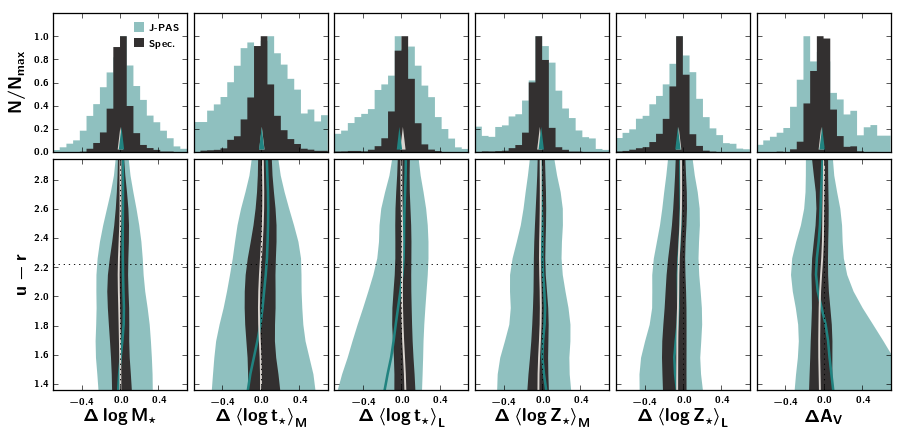

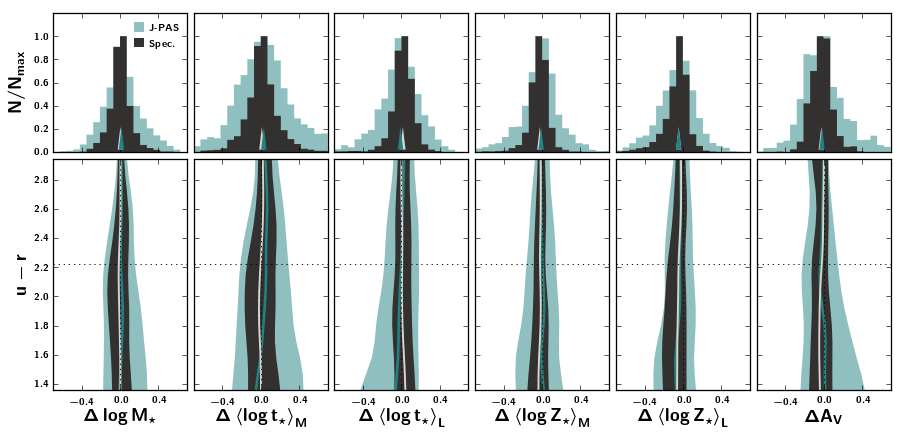

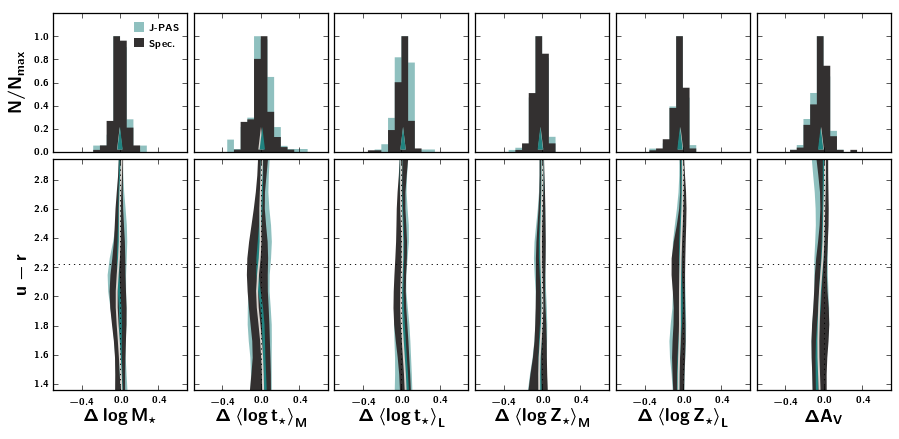

In [11]:
plot_residual_hist((spec_res_lsn, jpas_res_lsn), labels=(r"\bf Spec.", r"\bf J-PAS"), keywords=kws, res_lbs=Delta)
plot_residual_hist((spec_res_tta, jpas_res_tta), labels=(r"\bf Spec.", r"\bf J-PAS"), keywords=kws, res_lbs=Delta)
plot_residual_hist((spec_res_hsn, jpas_res_hsn), labels=(r"\bf Spec.", r"\bf J-PAS"), keywords=kws, res_lbs=Delta)

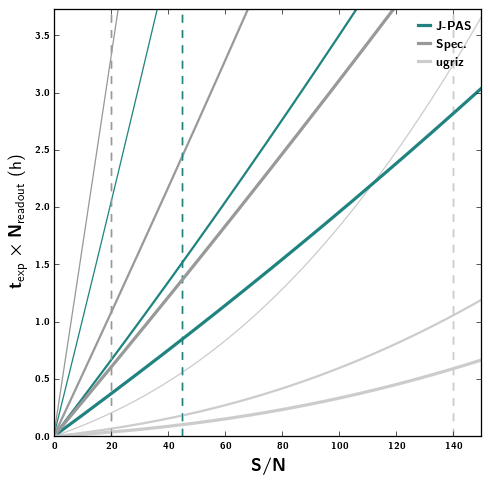

In [12]:
#select one galaxy in r=16,18,20 bins
bins = percentile(cat["r_mag"], [5,50,95])

true_snr = [snr["snr_wall"][argmin(abs(mag-cat["r_mag"]))] for mag in bins]
isort = argsort(true_snr)
true_snr = np.sort(true_snr)

spec_name = array([cat["input_file"][argmin(abs(mag-cat["r_mag"]))] for mag in bins])[isort]
true_mag = array([cat["r_mag"][argmin(abs(mag-cat["r_mag"]))] for mag in bins])[isort]

#get relevant data from FITS: expTime, readout noise, etc.
fdir = os.path.expandvars("$phd/inputs/real_deal/fits/")
spec_fits = [fits.open(fdir+fit) for fit in spec_name]
spec_expt = [f[0].header["EXPTIME"] for f in spec_fits]
spec_nr = [int(expt/60./15.) for expt in spec_expt]

F_spec = []
for i,f in enumerate(spec_fits):
    #read original (observed SED)
    wlen = array([10**(f[0].header["COEFF0"]+f[0].header["COEFF1"]*j) for j in xrange(f[0].header["NAXIS1"])])
    wlen /= 1.0 + 2.735182E-4 + 131.4182 / wlen**2 + 2.76249E8 / wlen**4
    flux = f[0].data[0]*1e-17
    wlen = wlen[flux>0]
    flux = flux[flux>0]
    #compute spectroscopic F = mean(F_lambda*h_s)
    F_spec.append(F(true_snr[i], F_sky=0.0, N_pix=N_pix_spec(), t=spec_nr[i]*spec_expt[i], readout_noise=spec_nr[i]*3.0))
    #using the expTime, reproduce the reported SNR values
    #print true_snr[i], SNR_astropy(spec_nr[i]*spec_expt[i], F_spec[i], 0.0, 0.0, spec_nr[i]*3.0, N_pix_spec())

#compute photometric F = sum(F_i*h_i)/nf ~ F_spec for the J-PAS filter set
F_pho = map(lambda x: x/0.25*0.5, F_spec)

tt = linspace(5.0, 60*4*56., 1000)
lws = [1, 1.75, 2.5]
for i in xrange(len(spec_name)):
    #compute the J-PAS SNR using the instrument values from Benitez et al. 2014
    SNR_jpas = lambda t: SNR_astropy(t, F_pho[i], 0.0, 0.0, 4., 56*4*N_pix_imag(D=3., ps=0.227))#SNR_phot(F_pho[i], t, dlambda=140., h=0.7, nf=56., D=3., nr=4., sigma=4., ps=0.2267)
    #also plot SDSS photometry for comparison
    SNR_ugriz = lambda t: SNR_astropy(t, F_pho[i], 0.0, 0.0, 4., 5*N_pix_imag(D=3., ps=0.396))#SNR_phot(F_pho[i], t, dlambda=1200., h=0.5, nf=5., D=3., nr=1., sigma=4., ps=0.396)
    #plot the SNR vs. t for the SDSS spectra and for the J-PAS
    SNR_sdss = lambda t: SNR_astropy(t, F_pho[i], 0.0, 0.0, 4., 3*N_pix_spec(R=1800., D=3., ps=0.396))#SNR_spec(F_spec[i], t, L=5400., h=0.3, nr=3.)

    axvline(45., ls="--", color="#218380", lw=1)
    axvline(20., ls="--", color="0.6", lw=1)
    axvline(140, ls="--", color="0.8", lw=1)

    if i==2:
        plot(SNR_jpas(tt), tt/3600, "-", color="#218380", lw=lws[i], label=r"\bf J-PAS")
        plot(SNR_sdss(tt), tt/3600, "-", color="0.6", lw=lws[i], label=r"\bf Spec.")
        plot(SNR_ugriz(tt), tt/3600, "-", color="0.8", lw=lws[i], label=r"\bf ugriz")
    else:
        plot(SNR_jpas(tt), tt/3600, "-", color="#218380", lw=lws[i])
        plot(SNR_sdss(tt), tt/3600, "-", color="0.6", lw=lws[i])
        plot(SNR_ugriz(tt), tt/3600, "-", color="0.8", lw=lws[i])

legend(loc=1, fontsize="x-small")
xlim(0,150)
ylim(0,tt.max()/3600)

xlabel(r"$S/N$")
ylabel(r"$t_\text{exp}\times N_\text{readout}$ (h)")